In [1]:
import numpy as np
import scipy.signal as ssgn
from matplotlib import pyplot as plt
%matplotlib inline

# работа со звуковыми файлами и данными
import essentia.standard as es
import essentia
import librosa

import IPython

# работа со звуковыми файлами формата .aif
import aifc

from collections import namedtuple

### Набор данных:
http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

#### Из 65000 файлов было выбрано 200: 20 произнесений каждой из 10-ти различных команд.
#### Отобранные файлы помещены в папку ../data/commands/!select
<br></br>
#### Каждый файл содержит звукозапись длительностью 1 секунда.
#### **Задача определения моментов начала и окончания звучания речи в проекте не рассматривается.**
#### Voice activity detection - тема, требующая отдельного не менее объёмного исследования.
<br></br>
#### Все файлы были размечены вручную. Маркеры сохранены внутри aif файлов. 

In [2]:
def get_metadata(file_path):
    """    
    Takes the path to .aif file, and returns 2 tuples:
    audio sampling rate, number of channels, sample width, data size in samples,
    markers.
    """
    try:
        with aifc.open(file_path, mode='rb') as aif_read:
            params = aif_read.getparams()
            markers = aif_read.getmarkers()
    except:
        print(f'Reading {sample_path} failed.')
    return params, markers

In [3]:
#sample_path = '../data/commands/!select/bed/0a7c2a8d_nohash_0.aif'
#sample_path = '../data/commands/!select/bird/1b459024_nohash_0.aif'
sample_path = '../data/commands/!select/bird/2dcb6848_nohash_0.aif'
#sample_path = '../data/commands/!select/bird/3b7f817e_nohash_0.aif'
#sample_path = '../data/commands/!select/dog/0fa1e7a9_nohash_0.aif'

In [4]:
params, markers = get_metadata(sample_path)

In [5]:
params

_aifc_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype=b'NONE', compname=b'not compressed')

In [6]:
markers

[(1, 5879, b'Marker 01'), (2, 14592, b'Marker 02')]

In [7]:
def get_float_data(file_path, sample_rate, padding=True, frame_size=512, hop_size=256):
    """
    Reads an .aif file.
    Takes the path, and returns float audio data in range [0, 1] as numpy array.
    """    
    loader = es.MonoLoader(filename=file_path, sampleRate=sample_rate)
    float_data = loader()
    if padding:
        actual_size = len(float_data)
        number_of_frames = int(np.floor((actual_size - frame_size) / hop_size) + 1)
        padded_size = (number_of_frames + 1) * hop_size + frame_size
        padding_length = padded_size - actual_size
        float_data = np.append(float_data, np.zeros(padding_length, dtype='float32'))
    return float_data

In [8]:
float_np_data = get_float_data(sample_path, params.framerate, padding=True)

In [9]:
IPython.display.Audio(data=float_np_data, rate=params.framerate)

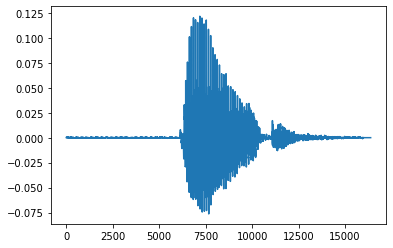

In [10]:
plt.plot(float_np_data);

In [11]:
vadregion = namedtuple('vadregion',['voiced','start_idx', 'stop_idx', 'size'])

In [12]:
def get_voice_presence(markers, data_size, frame_size, hop_size):
    first_frame = int(np.floor(markers[0][1] / hop_size))
    last_frame = int(np.ceil(markers[1][1] / hop_size))
    number_of_frames = int(np.floor((data_size - frame_size) / hop_size)) + 1
    presence_flags = []
    for i in range(number_of_frames):
        if first_frame <= i <= last_frame:
            presence_flags.append(True)
        else:
            presence_flags.append(False)
    presence_regions = []    
    presence_regions.append(vadregion._make([False, 0, first_frame - 1, first_frame - 1]))
    presence_regions.append(vadregion._make([True, first_frame, last_frame, last_frame - first_frame]))
    presence_regions.append(vadregion._make([False, last_frame + 1, number_of_frames - 1, number_of_frames - last_frame]))
    return presence_flags, presence_regions

In [13]:
presence_flags, presence_regions = get_voice_presence(markers, float_np_data.size, 512, 256)

In [14]:
def plot_flagged_frames(
        audio_data, vad_regions,
        hop_size=256, fig_size=(8,4),
        line_color='steelblue', line_style='solid', line_width=0.5,
        plot_grid=True, axes=None
    ):
    if axes is None:
        fig, ax = plt.subplots(figsize=fig_size)
    else:
        ax = axes    
    
    ax.plot(audio_data, color=line_color, ls=line_style, lw=line_width)
    if plot_grid:
        ax.grid()
    
    for reg in vad_regions:
        if reg.voiced:
            ax.axvspan(
                xmin=reg.start_idx * hop_size,
                xmax=reg.stop_idx * hop_size, color='grey', alpha=0.2
            )
    ax.set_xlim([0, len(audio_data)])

In [15]:
def plot_flagged_samples(
    audio_data, markers,
    fig_size=(8,4),
    line_color='steelblue', line_style='solid', line_width=0.5,
    plot_grid=True, axes=None
):
    if axes is None:
        fig, ax = plt.subplots(figsize=fig_size)
    else:
        ax = axes
        
    ax.plot(audio_data, color=line_color, ls=line_style, lw=line_width)
    if plot_grid:
        ax.grid()
    
    ax.axvspan(xmin=markers[0][1], xmax=markers[1][1], color='grey', alpha=0.2)
    ax.set_xlim([0, len(audio_data)])

#### **Визуализация сигнала и границ сегментов, содержащих речь.**

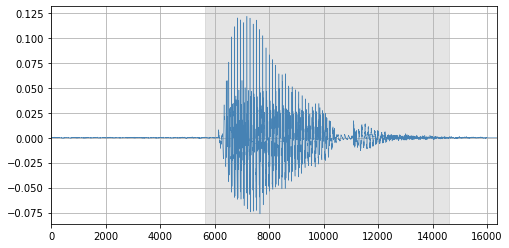

In [16]:
plot_flagged_frames(float_np_data, presence_regions)

#### **Первая стадия предобработки - подавление низкочастотных составляющих.**
#### С оговорками аналогично приведению среднего значения входных данных к нулю при нормализации.

In [17]:
dc_remover = es.DCRemoval(cutoffFrequency=40, sampleRate=params.framerate)

In [18]:
dc_remove_result = dc_remover(float_np_data)

#### **Вторая стадия предобработки - нормализация субъектвной громкости.**
#### С оговорками аналогично приведению дисперсии входных данных к единой величине при нормализации.

In [19]:
def apply_replay_gain(float_signal, sample_rate):
    downsampled_signal = es.Resample(inputSampleRate=sample_rate, outputSampleRate=8000)(float_signal)
    replay_gain_dB = es.ReplayGain(sampleRate=8000)(downsampled_signal)
    gain = np.power(10, replay_gain_dB / 20)
    return float_signal * gain, replay_gain_dB

In [20]:
normalized_signal, gain_dB = apply_replay_gain(dc_remove_result, params.framerate)

#### Нормализованный сигнал.

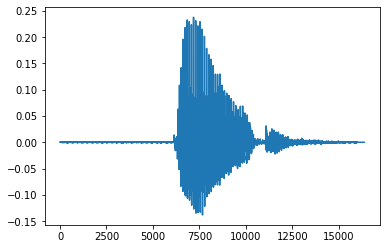

In [21]:
plt.plot(normalized_signal);

In [22]:
gain_dB

5.318080902099609

#### **Третья стадия предобработки - формирование перекрывающихся сегментов для short time analysis.**
#### Сигнал разбивается на последовательность сегментов, седржащих речь и фоновый шум.

In [23]:
def get_informative_frames(input_data, markers, parameters, frame_size, hop_size):
    first_informative_sample = markers[0][1]
    last_informative_sample = markers[1][1]
    noise_signal = np.append(input_data[0:first_informative_sample], input_data[last_informative_sample:])
    informative_signal = input_data[first_informative_sample : last_informative_sample]
    noise_rms = np.std(noise_signal)
    informative_rms = np.std(informative_signal)
    informative_duration = (last_informative_sample - first_informative_sample) / parameters.framerate
    first_informative_frame = int(np.floor(markers[0][1] / hop_size))
    last_informative_frame = int(np.ceil(markers[1][1] / hop_size))
    informative_frames = []
    noise_frames = []
    for frame_idx, frame in enumerate(es.FrameGenerator(input_data, frameSize=frame_size, hopSize=hop_size, startFromZero=True)):
        if first_informative_frame <= frame_idx <= last_informative_frame:
            informative_frames.append(frame)
        else:
            noise_frames.append(frame)
    return np.array(informative_frames), np.array(noise_frames), informative_duration, informative_rms, noise_rms

In [24]:
voice, noise, voice_dur, voice_rms, noise_rms = get_informative_frames(normalized_signal, markers, params, 512, 256)

In [25]:
voice_dur

0.5445625

In [26]:
voice_rms

0.032512702

In [27]:
noise_rms

0.0003683565

#### Вспомогательная функция для визуализации матрицы признаков с разбиением на сторки или на стобцы.

In [28]:
def waterfall_plot(
    frames, fig_size=(4,4), line_color='black', line_style='solid',
    line_width=0.5, overlap=0.5, axes=None, left_right=False,
    add_indices=False, font_size=6
    ):
    if axes is None:
        fig, ax = plt.subplots(figsize=fig_size)
    else:
        ax = axes

    data_max = np.max(frames)
    data_min = np.min(frames)
    plot_height = data_max - data_min
    plot_hop = (1 - overlap) * plot_height
    
    if left_right:
        frames = np.flipud(frames).T

    n = len(frames)
    full_height = (n - 1) * plot_hop + plot_height

    for i, frame in enumerate(frames):
        
        if left_right:
            plot_frame = plot_height + i * plot_hop - np.array(frame) + data_min
            ax.plot(plot_frame, range(len(plot_frame)), color=line_color, lw=line_width, ls=line_style)
            if add_indices:
                ax.text(plot_hop + i * plot_hop, -2, f'{i:>3}', rotation='vertical', fontsize=font_size)
        else:
            plot_frame = full_height - plot_height - i * plot_hop + np.array(frame) - data_min
            ax.plot(plot_frame, color=line_color, lw=line_width, ls=line_style)
            if add_indices:
                ax.text(-3, full_height - plot_height - i * plot_hop, f'{i:>3}', fontsize=font_size)

    if left_right:        
        ax.set_xlim([0, full_height])
    else:
        ax.set_ylim([0, full_height])
    ax.axis('off')

In [29]:
frames = librosa.feature.melspectrogram(normalized_signal, n_fft=512, hop_length=256, center=True)
frames = librosa.amplitude_to_db(frames)

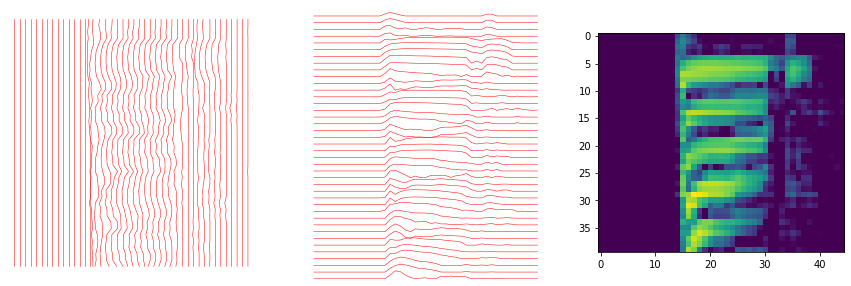

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
waterfall_plot(frames.T[10:55].T[:40], (4,4), line_color='red', overlap=0.25, left_right=True, axes=ax[0])
waterfall_plot(frames.T[10:55].T[:40], (4,4), line_color='red', overlap=0.25, left_right=False, axes=ax[1])
ax[2].imshow(frames.T[10:55].T[:40]);